In [1]:
print("checking if the kernel is working")


checking if the kernel is working


In [1]:
!pip uninstall -y numpy --quiet
!pip uninstall -y tensorflow --quiet
!pip install tensorflow==2.17 --quiet

from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
import tensorflow as tf
print(tf.__version__, "must be 2.17.0")
import numpy as np
print(np.__version__, "must be 1.26.4")
#from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import random, os, sys
from glob import glob

from matplotlib import pyplot as plt
import skimage

2024-12-05 15:11:56.952633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 15:11:56.977502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 15:11:56.985132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 15:11:57.006378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0 must be 2.17.0
1.26.4 must be 1.26.4
Num GPUs Available:  1


I0000 00:00:1733411519.244439   14256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733411519.296832   14256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733411519.297224   14256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


(64, 64, 285)
(64, 64, 4)
(4,)


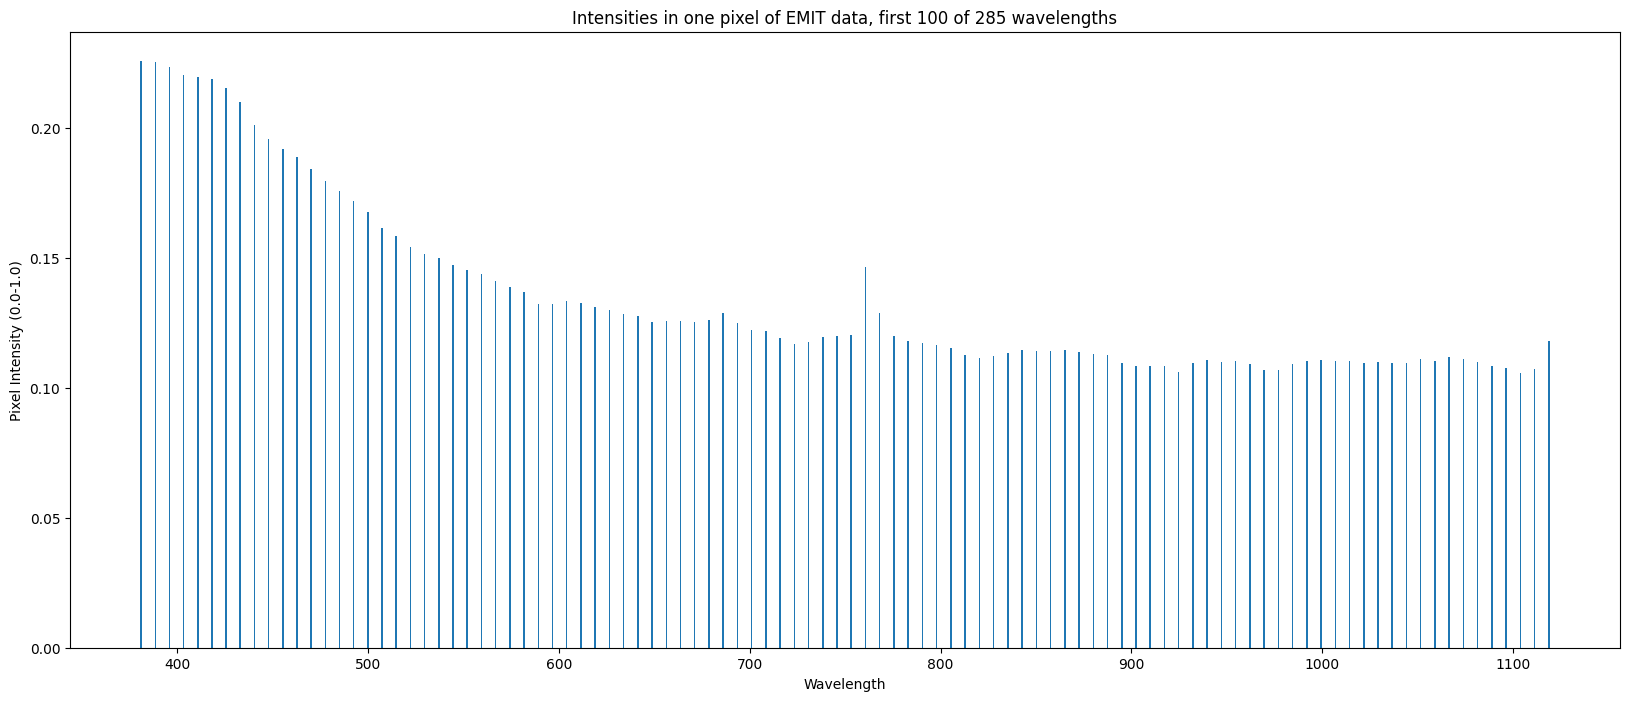

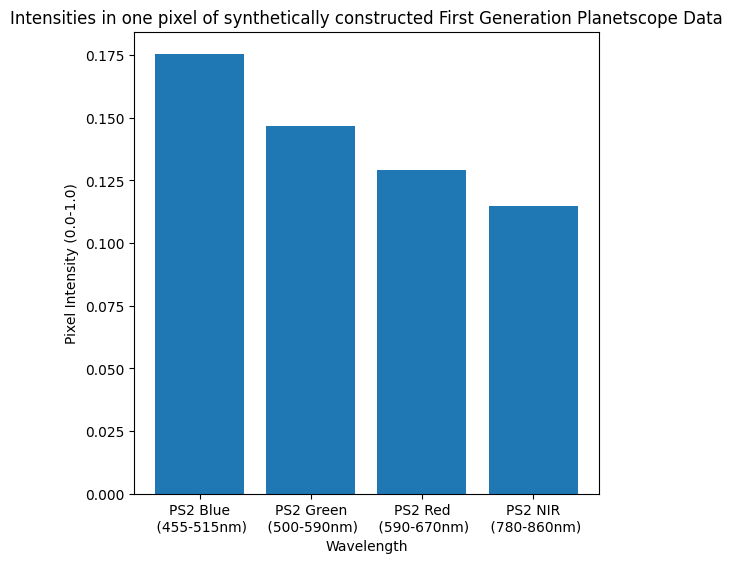

(64, 64, 285)
(64, 64, 8)
(8,)


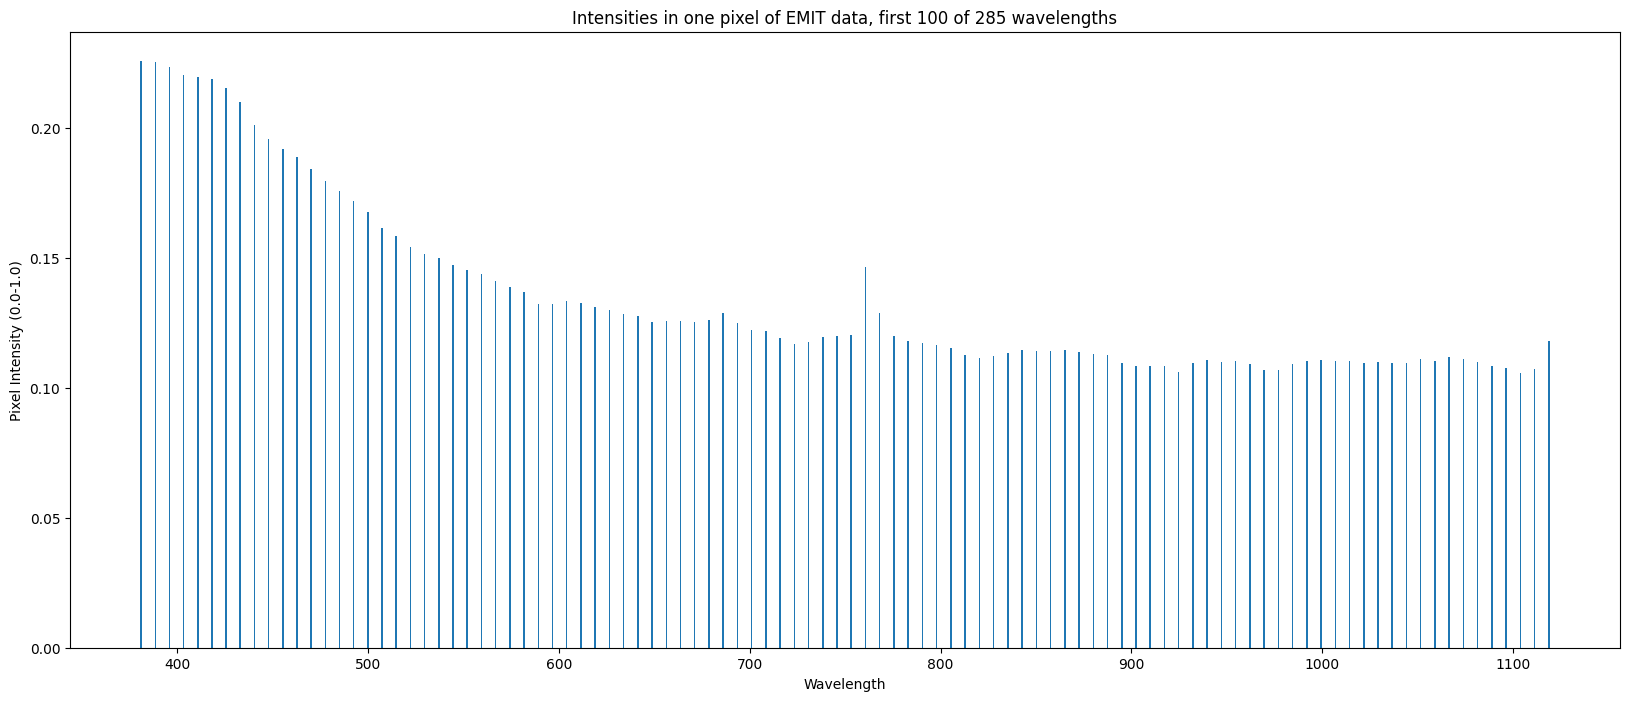

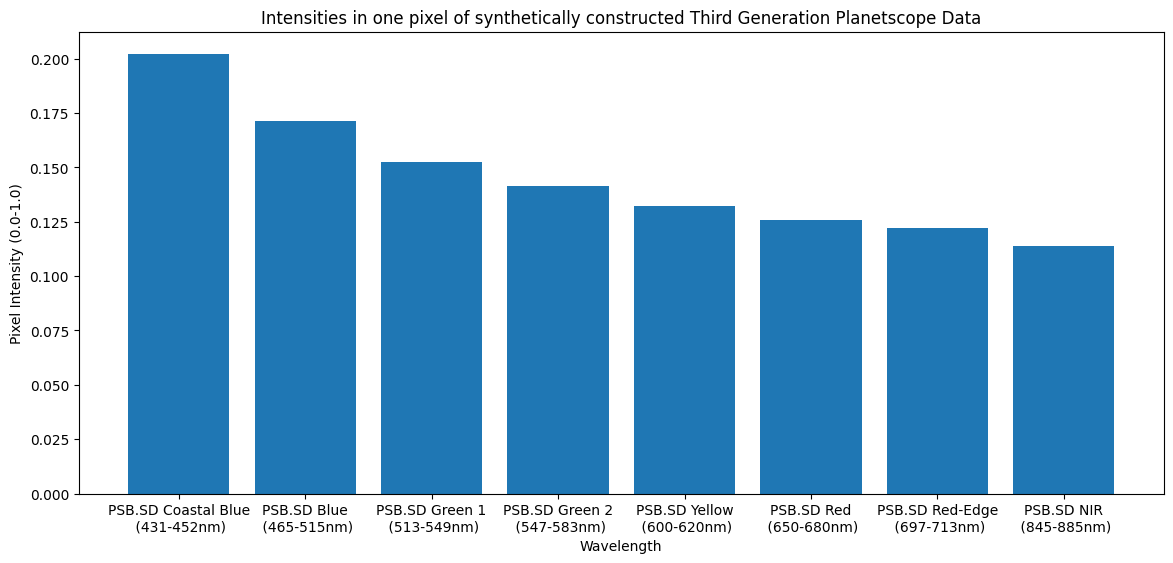

In [2]:
def average_wavelengths(chip, wavelength_indices):
    out_chip = chip[:,:,wavelength_indices]
    out_chip = np.nanmean(out_chip, axis=2)
    return out_chip

def convert_chip_to_different_spectra(chip, in_wavelengths, out_wavelengths, visualize=False):
    out_chip = []
    for out_wavelength_index in range(len(out_wavelengths)):
        out_wavelength_start = out_wavelengths[out_wavelength_index][0]
        out_wavelength_end = out_wavelengths[out_wavelength_index][1]
        
        in_wavelengths_to_grab = []
        for i in range(len(in_wavelengths)):
            in_wavelength = in_wavelengths[i]
            if in_wavelength > out_wavelength_start and in_wavelength < out_wavelength_end:
                in_wavelengths_to_grab.append(i)
        
        new_chip_at_wavelegnth = average_wavelengths(chip, in_wavelengths_to_grab)
        #print(new_chip_at_wavelegnth.shape)
        out_chip.append(new_chip_at_wavelegnth)
        
    out_chip = np.asarray(out_chip)
    out_chip = np.moveaxis(out_chip,0,2)
    #print(out_chip.shape)
    
    if visualize:
        print(chip.shape)
        print(out_chip.shape)
        print(out_chip[0,0,:].shape)
        
        num_wavelengths = 100
        fig = plt.figure(figsize = (20, 8))
        plt.bar(in_wavelengths[0:num_wavelengths], chip[0,0,0:num_wavelengths])
        plt.xlabel("Wavelength")
        plt.ylabel("Pixel Intensity (0.0-1.0)")
        plt.title("Intensities in one pixel of EMIT data, first 100 of 285 wavelengths")
        plt.show()
        
        num_wavelengths = len(out_wavelengths)
        if num_wavelengths == 4:
            string_wavelengths = ["PS2 Blue\n (455-515nm)", "PS2 Green\n (500-590nm)", "PS2 Red\n (590-670nm)", "PS2 NIR\n (780-860nm)"]
            fig = plt.figure(figsize = (6, 6))
            plt.bar(string_wavelengths, out_chip[0,0,:])
            plt.xlabel("Wavelength")
            plt.ylabel("Pixel Intensity (0.0-1.0)")
            plt.title("Intensities in one pixel of synthetically constructed First Generation Planetscope Data")
            plt.show()
            
        if num_wavelengths == 8:
            string_wavelengths = ["PSB.SD Coastal Blue\n (431-452nm)", "PSB.SD Blue\n (465-515nm)", "PSB.SD Green 1\n (513-549nm)", "PSB.SD Green 2\n (547-583nm)", "PSB.SD Yellow\n (600-620nm)", "PSB.SD Red\n (650-680nm)", "PSB.SD Red-Edge\n (697-713nm)", "PSB.SD NIR\n (845-885nm)", ]
            fig = plt.figure(figsize = (14, 6))
            plt.bar(string_wavelengths, out_chip[0,0,:])
            plt.xlabel("Wavelength")
            plt.ylabel("Pixel Intensity (0.0-1.0)")
            plt.title("Intensities in one pixel of synthetically constructed Third Generation Planetscope Data")
            plt.show()
    
    #PS2 = First Generation aka Dove
    #PS2.SD = Second Generation aka Dove-R
    #PSB.SD = Third Generation Planetscope aka SuperDove
    return out_chip

def convert_emit_chip_to_planetscope_chip(emit_chip_filename, planetscope_chip_filename, emit_wavelengths, planetscope_wavelengths, do_save=True, visualize=False):
    in_chip = np.load(emit_chip_filename)
    out_chip = convert_chip_to_different_spectra(in_chip, emit_wavelengths, planetscope_wavelengths, visualize=visualize)
    if do_save: np.save(planetscope_chip_filename, out_chip)
    
def convert_whole_dataset(emit_chip_directory, planetscope_chip_directory, emit_wavelengths, planetscope_wavelengths, chipname_prefix = "chip_", chipname_start_index=0, do_save=True, visualize=False):
    if not os.path.exists(planetscope_chip_directory):
        os.mkdir(planetscope_chip_directory)
        
    in_chip_paths = glob(os.path.join(emit_chip_directory,'*'))
    for chip_index, in_chip_path in enumerate(in_chip_paths):
        out_filename = chipname_prefix + f"{chipname_start_index+chip_index:05}" + ".npy"
        out_path = os.path.join(planetscope_chip_directory, out_filename)
        
        convert_emit_chip_to_planetscope_chip(in_chip_path, out_path, emit_wavelengths, planetscope_wavelengths, do_save=do_save, visualize=visualize)
        if visualize:
            break
            
        
#Src: https://assets.planet.com/docs/Planet_PSScene_Imagery_Product_Spec_letter_screen.pdf Pg 10
planetscope_old_wavelengths = [(455, 515), (500, 590), (590, 670), (780,860)]
planetscope_new_wavelengths = [(431,452), (465,515), (513,549), (547,583), (600,620), (650,680), (697,713), (845,885)]
        
emit_wavelengths = [ 381.00558,  388.4092 ,  395.81583,  403.2254 ,  410.638  ,
        418.0536 ,  425.47214,  432.8927 ,  440.31726,  447.7428 ,
        455.17035,  462.59888,  470.0304 ,  477.46292,  484.89743,
        492.33292,  499.77142,  507.2099 ,  514.6504 ,  522.0909 ,
        529.5333 ,  536.9768 ,  544.42126,  551.8667 ,  559.3142 ,
        566.7616 ,  574.20905,  581.6585 ,  589.108  ,  596.55835,
        604.0098 ,  611.4622 ,  618.9146 ,  626.36804,  633.8215 ,
        641.2759 ,  648.7303 ,  656.1857 ,  663.6411 ,  671.09753,
        678.5539 ,  686.0103 ,  693.4677 ,  700.9251 ,  708.38354,
        715.84094,  723.2993 ,  730.7587 ,  738.2171 ,  745.6765 ,
        753.1359 ,  760.5963 ,  768.0557 ,  775.5161 ,  782.97754,
        790.4379 ,  797.89935,  805.36176,  812.8232 ,  820.2846 ,
        827.746  ,  835.2074 ,  842.66986,  850.1313 ,  857.5937 ,
        865.0551 ,  872.5176 ,  879.98004,  887.44147,  894.90393,
        902.3664 ,  909.82886,  917.2913 ,  924.7538 ,  932.21625,
        939.6788 ,  947.14026,  954.6027 ,  962.0643 ,  969.5268 ,
        976.9883 ,  984.4498 ,  991.9114 ,  999.37286, 1006.8344 ,
       1014.295  , 1021.7566 , 1029.2172 , 1036.6777 , 1044.1383 ,
       1051.5989 , 1059.0596 , 1066.5201 , 1073.9797 , 1081.4404 ,
       1088.9    , 1096.3597 , 1103.8184 , 1111.2781 , 1118.7368 ,
       1126.1964 , 1133.6552 , 1141.1129 , 1148.5717 , 1156.0304 ,
       1163.4882 , 1170.9459 , 1178.4037 , 1185.8616 , 1193.3184 ,
       1200.7761 , 1208.233  , 1215.6898 , 1223.1467 , 1230.6036 ,
       1238.0596 , 1245.5154 , 1252.9724 , 1260.4283 , 1267.8833 ,
       1275.3392 , 1282.7942 , 1290.2502 , 1297.7052 , 1305.1603 ,
       1312.6144 , 1320.0685 , 1327.5225 , 1334.9756 , 1342.4287 ,
       1349.8818 , 1357.3351 , 1364.7872 , 1372.2384 , 1379.6907 ,
       1387.1418 , 1394.5931 , 1402.0433 , 1409.4937 , 1416.944  ,
       1424.3933 , 1431.8427 , 1439.292  , 1446.7404 , 1454.1888 ,
       1461.6372 , 1469.0847 , 1476.5321 , 1483.9796 , 1491.4261 ,
       1498.8727 , 1506.3192 , 1513.7649 , 1521.2104 , 1528.655  ,
       1536.1007 , 1543.5454 , 1550.9891 , 1558.4329 , 1565.8766 ,
       1573.3193 , 1580.7621 , 1588.205  , 1595.6467 , 1603.0886 ,
       1610.5295 , 1617.9705 , 1625.4104 , 1632.8513 , 1640.2903 ,
       1647.7303 , 1655.1694 , 1662.6074 , 1670.0455 , 1677.4836 ,
       1684.9209 , 1692.358  , 1699.7952 , 1707.2314 , 1714.6667 ,
       1722.103  , 1729.5383 , 1736.9727 , 1744.4071 , 1751.8414 ,
       1759.2749 , 1766.7084 , 1774.1418 , 1781.5743 , 1789.007  ,
       1796.4385 , 1803.8701 , 1811.3008 , 1818.7314 , 1826.1611 ,
       1833.591  , 1841.0206 , 1848.4495 , 1855.8773 , 1863.3052 ,
       1870.733  , 1878.16   , 1885.5869 , 1893.013  , 1900.439  ,
       1907.864  , 1915.2892 , 1922.7133 , 1930.1375 , 1937.5607 ,
       1944.9839 , 1952.4071 , 1959.8295 , 1967.2518 , 1974.6732 ,
       1982.0946 , 1989.515  , 1996.9355 , 2004.355  , 2011.7745 ,
       2019.1931 , 2026.6118 , 2034.0304 , 2041.4471 , 2048.865  ,
       2056.2808 , 2063.6965 , 2071.1123 , 2078.5273 , 2085.9421 ,
       2093.3562 , 2100.769  , 2108.1821 , 2115.5942 , 2123.0063 ,
       2130.4175 , 2137.8289 , 2145.239  , 2152.6482 , 2160.0576 ,
       2167.467  , 2174.8755 , 2182.283  , 2189.6904 , 2197.097  ,
       2204.5034 , 2211.9092 , 2219.3147 , 2226.7195 , 2234.1233 ,
       2241.5269 , 2248.9297 , 2256.3328 , 2263.7346 , 2271.1365 ,
       2278.5376 , 2285.9387 , 2293.3386 , 2300.7378 , 2308.136  ,
       2315.5342 , 2322.9326 , 2330.3298 , 2337.7263 , 2345.1216 ,
       2352.517  , 2359.9126 , 2367.3071 , 2374.7007 , 2382.0935 ,
       2389.486  , 2396.878  , 2404.2695 , 2411.6604 , 2419.0513 ,
       2426.4402 , 2433.8303 , 2441.2183 , 2448.6064 , 2455.9944 ,
       2463.3816 , 2470]
    
emit_dataset_path_0 = "./reflectance/"
emit_dataset_path_1 = "./reflectance_1/"
emit_dataset_path_2 = "./reflectance_2/"
emit_dataset_path_3 = "./reflectance_3/"
emit_dataset_path_4 = "./reflectance_4/"
emit_dataset_path_5 = "./reflectance_5/"


# planetscope_old_dataset_path = "./dataset_for_cnn/train/x/"
# planetscope_new_dataset_path = "./dataset_for_cnn/train/y/"


if True:
    convert_whole_dataset(emit_dataset_path_3, "./dataset_for_cnn/train/x/", emit_wavelengths, planetscope_old_wavelengths, chipname_prefix = "chip_", chipname_start_index=100000, do_save=False, visualize=True)
    convert_whole_dataset(emit_dataset_path_3, "./dataset_for_cnn/train/x/", emit_wavelengths, planetscope_new_wavelengths, chipname_prefix = "chip_", chipname_start_index=100000, do_save=False, visualize=True)

if False: #manual toggle since this only needs to happen once
    #Granule 0:
    print("Processing granule 0")
    convert_whole_dataset(emit_dataset_path_0, "./dataset_for_cnn/train/x/", emit_wavelengths, planetscope_old_wavelengths, chipname_prefix = "chip_")
    convert_whole_dataset(emit_dataset_path_0, "./dataset_for_cnn/train/y/", emit_wavelengths, planetscope_new_wavelengths, chipname_prefix = "chip_")
    print("Granule 0 processed into train data")

    #Granule 1:
    print("Processing granule 1")
    convert_whole_dataset(emit_dataset_path_1, "./dataset_for_cnn/test/x/", emit_wavelengths, planetscope_old_wavelengths, chipname_prefix = "chip_")
    convert_whole_dataset(emit_dataset_path_1, "./dataset_for_cnn/test/y/", emit_wavelengths, planetscope_new_wavelengths, chipname_prefix = "chip_")
    print("Granule 1 processed into test data")

    # #Granule 2:
    print("Processing granule 2")
    convert_whole_dataset(emit_dataset_path_2, "./dataset_for_cnn/valid/x/", emit_wavelengths, planetscope_old_wavelengths, chipname_prefix = "chip_")
    convert_whole_dataset(emit_dataset_path_2, "./dataset_for_cnn/valid/y/", emit_wavelengths, planetscope_new_wavelengths, chipname_prefix = "chip_")
    print("Granule 2 processed into valid data")
    
    # #Granule 3:
    print("Processing granule 3")
    convert_whole_dataset(emit_dataset_path_3, "./dataset_for_cnn/train/x/", emit_wavelengths, planetscope_old_wavelengths, chipname_prefix = "chip_", chipname_start_index=10000)
    convert_whole_dataset(emit_dataset_path_3, "./dataset_for_cnn/train/y/", emit_wavelengths, planetscope_new_wavelengths, chipname_prefix = "chip_", chipname_start_index=10000)
    print("Granule 3 processed into train data")
    
    # #Granule 4:
    print("Processing granule 4")
    convert_whole_dataset(emit_dataset_path_4, "./dataset_for_cnn/train/x/", emit_wavelengths, planetscope_old_wavelengths, chipname_prefix = "chip_", chipname_start_index=20000)
    convert_whole_dataset(emit_dataset_path_4, "./dataset_for_cnn/train/y/", emit_wavelengths, planetscope_new_wavelengths, chipname_prefix = "chip_", chipname_start_index=20000)
    print("Granule 4 processed into train data")
    
    # #Granule 5:
    print("Processing granule 5")
    convert_whole_dataset(emit_dataset_path_5, "./dataset_for_cnn/train/x/", emit_wavelengths, planetscope_old_wavelengths, chipname_prefix = "chip_", chipname_start_index=30000)
    convert_whole_dataset(emit_dataset_path_5, "./dataset_for_cnn/train/y/", emit_wavelengths, planetscope_new_wavelengths, chipname_prefix = "chip_", chipname_start_index=30000)
    print("Granule 5 processed into train data")

In [3]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, x_chip_path_dir, y_chip_path_dir, batch_size, shuffle=True):
        super().__init__()
        self.x_chip_path_dir = x_chip_path_dir
        self.y_chip_path_dir = y_chip_path_dir
        
        self.x_chip_path_list = glob(os.path.join(self.x_chip_path_dir,'*'))
        self.y_chip_path_list = glob(os.path.join(self.y_chip_path_dir,'*'))
        
        self.num_files = len(self.x_chip_path_list)
        self.index_path = list(range(self.num_files))+list(range(self.num_files))
        self.batch_size = batch_size
        self.shuffle = shuffle
        if self.shuffle == True:
            random.shuffle(self.index_path)
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.index_path)
    
    def __getitem__(self, index, debug=False):
        X = []
        Y = []
        for i in range(self.batch_size):
            if debug: print(i, "Index:", self.index_path[i+index], "Path:", self.y_chip_path_list[self.index_path[i+index]])
            #if debug: print(self.index_path)
            x = np.load(self.x_chip_path_list[self.index_path[i+index]])
            y = np.load(self.y_chip_path_list[self.index_path[i+index]])
            
            X.append(x)
            Y.append(y)
        
        X = np.asarray(X).astype('float32')
        Y = np.asarray(Y).astype('float32')
       
        
       # # print(np.isnan(np.min(X)))
       #  x = np.asarray(x).astype('float32')
       #  x = np.zeros((1, 64, 64, 4))
       #  y = np.zeros((1,64,64,8))
       #  print(x)
        # X = tf.convert_to_tensor(X.tolist())
        # Y = tf.convert_to_tensor(Y.tolist())
        
        return X, Y
    
    def __len__(self):
        return self.num_files // self.batch_size


In [24]:
def generate_fcn_model(num_hidden_layers=3, first_layer_num_filters=32, first_layer_kernel_size=3, hidden_layer_num_filters=64, hidden_layer_kernel_size=3, layer_activation='sigmoid'):
    # num_hidden_layers must be > 1
    # *_num_filters must be positive integer - recommend 8, 16, 32, 64, etc
    # *_kernel_size must be odd positive integer - recommend 1, 3, 5, 7, 9, etc
    # see documentation for tf.keras for different activations
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(first_layer_num_filters, (first_layer_kernel_size, first_layer_kernel_size), activation=layer_activation, padding='same'))
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Conv2D(hidden_layer_num_filters, (hidden_layer_kernel_size, hidden_layer_kernel_size), activation=layer_activation, padding='same'))
    model.add(tf.keras.layers.Conv2D(8, (3, 3), activation='sigmoid', padding='same'))
    
    return model

#adapted from: https://github.com/oekosheri/tensorflow_unet_scaling/blob/main/models.py
def conv_block(input, num_filters, conv_block_size=2, do_batchnorm=True, activation="relu"):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    if do_batchnorm == True:
        x = tf.keras.layers.BatchNormalization()(x)  # Not in the original network.
    x = tf.keras.layers.Activation(activation)(x)
    
    for i in range(conv_block_size-1):
        x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
        if do_batchnorm == True:
            x = tf.keras.layers.BatchNormalization()(x)  # Not in the original network
        x = tf.keras.layers.Activation(activation)(x)
        
    return x

def encoder_block(input, num_filters, conv_block_size=2, do_batchnorm=True, activation="relu"):
    x = conv_block(input, num_filters, conv_block_size=conv_block_size, do_batchnorm=do_batchnorm, activation=activation)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters, conv_block_size=2, do_batchnorm=True, activation="relu"):
    
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, conv_block_size=conv_block_size, do_batchnorm=do_batchnorm, activation=activation)
    return x

def generate_unet_model(unet_depth=3, num_filters_base=8, conv_block_size=2, do_batchnorm=True, activation="relu"):
    inputs = tf.keras.layers.Input((64,64,4)) #Assuming 64x64x4 chipsize
    
    s_list = []
    p_list = []
    d_list = []
    num_filters = num_filters_base    
    
    #encoding steps
    for i in range(unet_depth):
        if i == 0:
            s, p = encoder_block(inputs, num_filters, conv_block_size=conv_block_size, do_batchnorm=do_batchnorm, activation=activation)
        else:
            s, p = encoder_block(p_list[i-1], num_filters, conv_block_size=conv_block_size, do_batchnorm=do_batchnorm, activation=activation)
        s_list.append(s)
        p_list.append(p)
        num_filters *= 2
        
    #bridge
    b1 = conv_block(p_list[-1], num_filters, conv_block_size=conv_block_size, do_batchnorm=do_batchnorm, activation=activation)
    num_filters = int(num_filters/2)
    
    #decoding steps:
    for i in range(unet_depth):
        if i == 0:
            d = decoder_block(b1, s_list[-1-i], num_filters, conv_block_size=conv_block_size, do_batchnorm=do_batchnorm, activation=activation)
        else:
            d = decoder_block(d_list[i-1], s_list[-1-i], num_filters, conv_block_size=conv_block_size, do_batchnorm=do_batchnorm, activation=activation)
            
        d_list.append(d)
        num_filters = int(num_filters/2)
    
    #head
    output = tf.keras.layers.Conv2D(8, (3, 3), activation=activation, padding='same')(d_list[-1])
    model = tf.keras.models.Model(inputs, output, name="U-Net")
    return model


#adapted from: https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/
def identity_block(x, num_filters):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(num_filters, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(num_filters, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, num_filters):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(num_filters, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(num_filters, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(num_filters, (1,1))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def generate_resnet_model(num_filters=64, block_layers=[3,4,6,3]):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input((64,64,4)) #Assuming 64x64x4 chipsize

    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=3, padding='same')(x_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Define size of sub-blocks and initial filter size
    # block_layers = [3, 4, 6, 3]
    # filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(len(block_layers)):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, num_filters)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            x = convolutional_block(x, num_filters)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, num_filters)
                
    # head
    output = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    model = tf.keras.models.Model(x_input, output, name="ResNet")
    return model

In [5]:
def train_model(model, batch_size=1, num_epochs=10, learning_rate=1e-3, model_checkpoint_directory="./saved_models/temp/", model_checkpoint_filename="temp_current_best.keras"):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MeanAbsoluteError(), metrics=['accuracy', 'root_mean_squared_error'])
    #print(model.summary())
    training_generator = CustomDataGenerator("./dataset_for_cnn/train/x/", "./dataset_for_cnn/train/y/", batch_size)
    validation_generator = CustomDataGenerator("./dataset_for_cnn/valid/x/", "./dataset_for_cnn/valid/y/", batch_size)
    early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=20, start_from_epoch=40, verbose=1)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                    filepath=os.path.join(model_checkpoint_directory,model_checkpoint_filename),
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

    
    history = model.fit(training_generator,
                        validation_data=validation_generator,
                        epochs=num_epochs,
                        callbacks=[early_stop_callback, model_checkpoint_callback]
                        )
    return model, history
    
def score_one_datapoint(y, y_pred):
    psnr = skimage.metrics.peak_signal_noise_ratio(np.asarray(y), y_pred)
    ssim = skimage.metrics.structural_similarity(np.asarray(y), y_pred, data_range = 1)
    mse = skimage.metrics.mean_squared_error(np.asarray(y), y_pred)
    return psnr, ssim, mse
    
def test_and_score_model(model, verbose=False, num_samples=32, debug=False, return_all_bands=False, visualize_results=False, visualize_index=0, visualize_band=0):
    testing_generator = CustomDataGenerator("./dataset_for_cnn/test/x/", "./dataset_for_cnn/test/y/", num_samples)
    psnr_list = []
    ssim_list = []
    mse_list = []
    
    print("Testing and Scoring Model...")
    
    x, y = testing_generator.__getitem__(0, debug=False)
    
    #print(y[0]-y[1])
    
    y_pred = model.predict(x, steps=num_samples, verbose=0)
    if debug: print(y_pred.shape, y.shape)
    
    for band_index in range(8):
        psnr_list.append([])
        ssim_list.append([])
        mse_list.append([])
        
        for image_index in range(num_samples):
            psnr, ssim, mse = score_one_datapoint(y[image_index,:,:,band_index], y_pred[image_index,:,:,band_index])
            psnr_list[band_index].append(psnr)
            ssim_list[band_index].append(ssim)
            mse_list[band_index].append(mse)
    
    if debug: print(np.asarray(psnr_list).shape)
    avg_psnr = [np.mean(np.asarray(psnr_sublist)) for psnr_sublist in psnr_list]
    avg_ssim = [np.mean(np.asarray(ssim_sublist)) for ssim_sublist in ssim_list]
    avg_mse =  [np.mean(np.asarray(mse_sublist)) for mse_sublist in mse_list]
    
    if verbose:
        print("PSB.SD Bands: Coastal Blue, Blue, Green 1, Green 2, Yellow, Red, Red-Edge, NIR")
        print("Average PSNR Per Band:", *(f"{x:.3f}" for x in avg_psnr), "All Bands:", f"{np.mean(avg_psnr):.3f}")
        print("Average SSIM Per Band:", *(f"{x:.3f}" for x in avg_ssim), "All Bands:", f"{np.mean(avg_ssim):.3f}")
        print("Average MSE Per Band:", *(f"{x:.5f}" for x in avg_mse), "All Bands:", f"{np.mean(avg_mse):.5f}")
        
    if visualize_results:
        print("y range:", np.min(y), np.mean(y), np.max(y))
        print("ypred  :", np.min(y_pred), np.mean(y_pred), np.max(y_pred))
        f, axarr = plt.subplots(2,8) 
        f.set_figheight(8)
        f.set_figwidth(24)
        for i in range(8):
            ymin = min(np.min(y[visualize_index,:,:,i]), np.min(y_pred[visualize_index,:,:,i]))
            ymax = max(np.max(y[visualize_index,:,:,i]), np.max(y_pred[visualize_index,:,:,i]))
            axarr[0][i].imshow(y[visualize_index,:,:,i], vmin=ymin, vmax=ymax)
            axarr[1][i].imshow(y_pred[visualize_index,:,:,i], vmin=ymin, vmax=ymax)
    
        
    if debug:
        return psnr_list, ssim_list, mse_list
    elif return_all_bands:
        return avg_psnr, avg_ssim, avg_mse
    else:
        return np.mean(avg_psnr), np.mean(avg_ssim), np.mean(avg_mse)
    
    
def interrogate_data():
    training_generator = CustomDataGenerator("./dataset_for_cnn/train/x/", "./dataset_for_cnn/train/y/", 512)
    validation_generator = CustomDataGenerator("./dataset_for_cnn/valid/x/", "./dataset_for_cnn/valid/y/", 512)
    testing_generator = CustomDataGenerator("./dataset_for_cnn/test/x/", "./dataset_for_cnn/test/y/", 512)
    
    x, y = training_generator.__getitem__(0)
    print("Training X:  Min:", np.min(x), "Max:", np.max(x), "Mean:", np.mean(x, axis=(0,1,2)), "shape:", np.shape(x))
    print("Training Y:  Min:", np.min(y), "Max:", np.max(y), "Mean:", np.mean(y, axis=(0,1,2)), "shape:", np.shape(y))

    x, y = validation_generator.__getitem__(0)
    print("Validation X:  Min:", np.min(x), "Max:", np.max(x), "Mean:", np.mean(x, axis=(0,1,2)), "shape:", np.shape(x))
    print("Validation Y:  Min:", np.min(y), "Max:", np.max(y), "Mean:", np.mean(y, axis=(0,1,2)), "shape:", np.shape(y))
    
    x, y = testing_generator.__getitem__(0)
    print("Testing X:  Min:", np.min(x), "Max:", np.max(x), "Mean:", np.mean(x, axis=(0,1,2)), "shape:", np.shape(x))
    print("Testing Y:  Min:", np.min(y), "Max:", np.max(y), "Mean:", np.mean(y, axis=(0,1,2)), "shape:", np.shape(y))


In [6]:
#interrogate_data()
#avg_psnr, avg_ssim, avg_mse = test_and_score_model(final_model, verbose=True, num_samples=128, debug=False, visualize_results=True, visualize_index=0, visualize_band=0)

In [7]:
def do_model_training(model=None, training_params=None, fcn_model_params=None, unet_model_params=None, resnet_model_params=None, lr=1e-4, model_save_dir="./saved_models/temp/", model_type="fcn", visualize=False):
    if not os.path.exists(model_save_dir):
            os.mkdir(model_save_dir)

    ## Training Parameters
    #TODO: Play with these values first to see if you can get models to converge quickly
    if training_params == None:
        print("No training params given, reverting to defaults")
        batch_size = 32              #Normally you want to push this as high as you can, multiples of 2, until you run out of VRAM
        num_epochs = 1000             #Increase to train more.  May need to be increased as batch size is increased to keep number of training steps equal
        learning_rate = 1e-4        #Play with this to get models to converge faster
    else:
        batch_size = training_params['batch_size']
        num_epochs = training_params['num_epochs']
        learning_rate = training_params['learning_rate']
        
        
    if model == None and model_type == "fcn":
        ## FCN Model Parameters
        #TODO: Grid-Search these, log PSNR, SSIM, MSE for each trained model in a spreadsheet:
        if fcn_model_params == None:
            print("No fcn params given, reverting to defaults")
            num_hidden_layers=3         #try 0,1,2,3,4,5,...,12     This will be the most important feature probably
            first_layer_num_filters=32  #try 4,8,16,32,64,128       This might be important but can be dropped
            first_layer_kernel_size=3   #try 1,3,5,7,9 must be odd  Least important, first to drop
            hidden_layer_num_filters=64 #try 4,8,16,32,64,128       Probably the second most important feature
            hidden_layer_kernel_size=3  #try 1,3,5,7,9 must be odd  Least important, first to drop
            layer_activation='sigmoid'  #try sigmoid and relu       This might be important but can be dropped
        else:
            num_hidden_layers=fcn_model_params['num_hidden_layers']
            first_layer_num_filters=fcn_model_params['first_layer_num_filters']
            first_layer_kernel_size=fcn_model_params['first_layer_kernel_size']
            hidden_layer_num_filters=fcn_model_params['hidden_layer_num_filters']
            hidden_layer_kernel_size=fcn_model_params['hidden_layer_kernel_size']
            layer_activation=fcn_model_params['layer_activation']
            
        ## Generate FCM
        best_model_name = f"fcm_bs{batch_size}_lr{learning_rate}_layers{num_hidden_layers}_filter1{first_layer_num_filters}_size1{first_layer_kernel_size}_filterN{hidden_layer_num_filters}_sizeN{hidden_layer_kernel_size}_activ{layer_activation}_best.keras"
        final_model_name= f"fcm_bs{batch_size}_lr{learning_rate}_layers{num_hidden_layers}_filter1{first_layer_num_filters}_size1{first_layer_kernel_size}_filterN{hidden_layer_num_filters}_sizeN{hidden_layer_kernel_size}_activ{layer_activation}_final.keras"
        model = generate_fcn_model(num_hidden_layers=num_hidden_layers, 
                               first_layer_num_filters=first_layer_num_filters, 
                               first_layer_kernel_size=first_layer_kernel_size, 
                               hidden_layer_num_filters=hidden_layer_num_filters, 
                               hidden_layer_kernel_size=hidden_layer_kernel_size,
                               layer_activation=layer_activation)
            
    elif model == None and model_type == "unet":
        ## U-Net Model Parameters
        #TODO: Grid-Search these, log PSNR, SSIM, MSE for each trained model in a spreadsheet:
        if unet_model_params == None:
            print("No fcn params given, reverting to defaults")
            unet_depth=3             #try 1,2,3,4,5,6,7,8
            num_filters_base=8       #try 4,8,16,32
            conv_block_size=2        #try 1,2,3,4,5,6,7,8
            do_batchnorm=True        #try true/false
            activation="relu"        #try sigmoid and relu
        else:
            unet_depth=unet_model_params['unet_depth']
            num_filters_base=unet_model_params['num_filters_base']
            conv_block_size=unet_model_params['conv_block_size']
            do_batchnorm=unet_model_params['do_batchnorm']
            activation=unet_model_params['activation']

        # Generate U-Net
        best_model_name = f"unet_bs{batch_size}_lr{learning_rate}_depth{unet_depth}_basefilters{num_filters_base}_cblocksize{conv_block_size}_BN{do_batchnorm}_activ{activation}_best.keras"
        final_model_name= f"unet_bs{batch_size}_lr{learning_rate}_depth{unet_depth}_basefilters{num_filters_base}_cblocksize{conv_block_size}_BN{do_batchnorm}_activ{activation}_final.keras"
        model = generate_unet_model(unet_depth=unet_depth, 
                                    num_filters_base=num_filters_base, 
                                    conv_block_size=conv_block_size, 
                                    do_batchnorm=do_batchnorm, 
                                    activation=activation)
        
    elif model == None and model_type == "resnet":
        ## Resnet Model Parameters:
        if resnet_model_params == None:
            num_filters = 64
            block_layers = [2,2,2,2] #[3,4,6,3]
        else:
            num_filters = resnet_model_params['num_filters']
            block_layers = resnet_model_params['block_layers']
            
        # Generate ResNet:
        block_layers_string = ''
        for blocksize in block_layers:
            block_layers_string += str(blocksize)+'_'
        best_model_name = f"resnet_bs{batch_size}_lr{learning_rate}_num_filters{num_filters}_block_layers{block_layers_string}_best.keras"
        final_model_name= f"resnet_bs{batch_size}_lr{learning_rate}_num_filters{num_filters}_block_layers{block_layers_string}_final.keras"
        
        model = generate_resnet_model(num_filters=num_filters, block_layers=block_layers)
        
    elif model == None:
        print("No model type given, must be fcn, unet, resnet")
    else:
        print("Using existing model")
    
    print(model.summary())
    
    ## Train Model
    model, history = train_model(model, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, model_checkpoint_directory=model_save_dir, model_checkpoint_filename=best_model_name)
    model.save(os.path.join(model_save_dir, final_model_name))
    
    
    if visualize:
        ## Plot Training Progress
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    
    best_model = tf.keras.models.load_model(os.path.join(model_save_dir, best_model_name))
    return model, best_model, history

No training params given, reverting to defaults


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 64, 64,    │      2,368 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_83[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_62       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_62[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_84[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_63[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_85[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_62[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 64, 64,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_64[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_86[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_65[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_87[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 64, 64,    │      4,160 │ activation_64[0]

 Total params: 317,192 (1.21 MB)

 Trainable params: 316,040 (1.21 MB)

 Non-trainable params: 1,152 (4.50 KB)

None
Epoch 1/1000


2024-12-05 15:38:56.244278: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 4159: 3.6051, expected 3.0108
2024-12-05 15:38:56.244384: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 5375: 4.89627, expected 4.30196
2024-12-05 15:38:56.244413: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 8191: 4.00341, expected 3.40911
2024-12-05 15:38:56.244423: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 8255: 2.84315, expected 2.41376
2024-12-05 15:38:56.244459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 12288: 5.16831, expected 4.1754
2024-12-05 15:38:56.244468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 12289: 7.4947, expected 6.50179
2024-12-05 15:38:56.244476: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 12290: 6.77331, expected 5.7804
2024-12-05 15:38:56.244485: E external/loca

72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.3409 - loss: 0.2107 - root_mean_squared_error: 0.4639 - val_accuracy: 2.8633e-04 - val_loss: 0.2481 - val_root_mean_squared_error: 0.2823
Epoch 2/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6030 - loss: 0.0845 - root_mean_squared_error: 0.1332 - val_accuracy: 0.0066 - val_loss: 0.1708 - val_root_mean_squared_error: 0.2102
Epoch 3/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5799 - loss: 0.0648 - root_mean_squared_error: 0.1086 - val_accuracy: 0.0140 - val_loss: 0.0834 - val_root_mean_squared_error: 0.1196
Epoch 4/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6172 - loss: 0.0481 - root_mean_squared_error: 0.0881 - val_accuracy: 0.0051 - val_loss: 0.0640 - val_root_mean_squared_error: 0.0961
Epoch 5/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6251 - loss: 0.0400 - root_mean_squared_error: 0.0715 - val_accuracy: 0.0373 - val_loss: 0.0553 - val_root_mean_squared_error: 0.0977
Epo

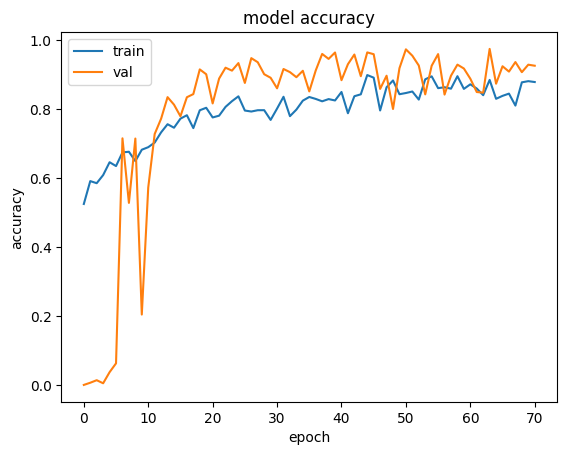

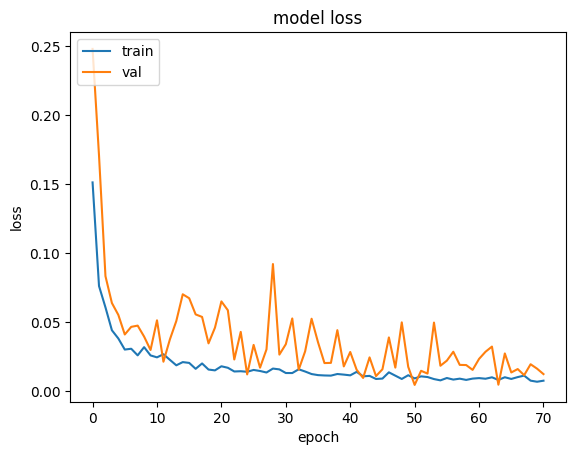

In [25]:

fcn_model_params_smol = {
    'num_hidden_layers' : 3,
    'first_layer_num_filters' : 32,
    'first_layer_kernel_size' : 3,
    'hidden_layer_num_filters' : 64,
    'hidden_layer_kernel_size' : 3,
    'layer_activation' : 'sigmoid'
}
fcn_model_params_big = {
    'num_hidden_layers' : 8,
    'first_layer_num_filters' : 32,
    'first_layer_kernel_size' : 3,
    'hidden_layer_num_filters' : 64,
    'hidden_layer_kernel_size' : 3,
    'layer_activation' : 'sigmoid'
}
unet_model_params_smol = {
    'unet_depth' : 3,
    'num_filters_base' : 8,
    'conv_block_size' : 2,
    'do_batchnorm' : True,
    'activation' : "relu",
}
unet_model_params_deep = {
    'unet_depth' : 4,
    'num_filters_base' : 8,
    'conv_block_size' : 2,
    'do_batchnorm' : True,
    'activation' : "relu",
}
unet_model_params_thic = {
    'unet_depth' : 3,
    'num_filters_base' : 16,
    'conv_block_size' : 3,
    'do_batchnorm' : True,
    'activation' : "relu",
}
resnet_model_params_smol = {
    'num_filters' : 64,
    'block_layers' : [1,1,1,1],
}
resnet_model_params_med = {
    'num_filters' : 64,
    'block_layers' : [2,2,2,2],
}
resnet_model_params_large = {
    'num_filters' : 64,
    'block_layers' : [3,3,3,3],
}


final_model, best_model, history = do_model_training(resnet_model_params=resnet_model_params_smol, lr=1e-4, model_save_dir="./saved_models/manual_search/", model_type="resnet", visualize=True)

Testing and Scoring Model...


2024-12-05 15:42:58.121090: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 8192: 3.49394, expected 4.04462
2024-12-05 15:42:58.121141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 8255: 2.31277, expected 2.86345
2024-12-05 15:42:58.121179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 9600: 3.65785, expected 4.20853
2024-12-05 15:42:58.121212: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 12287: 2.69739, expected 3.24807
2024-12-05 15:42:58.121255: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 16447: 3.38625, expected 3.89429
2024-12-05 15:42:58.121297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 20479: 3.27327, expected 3.78132
2024-12-05 15:42:58.121319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 20543: 2.76068, expected 3.2444
2024-12-05 15:42:58.121381: E external

PSB.SD Bands: Coastal Blue, Blue, Green 1, Green 2, Yellow, Red, Red-Edge, NIR
Average PSNR Per Band: 31.994 36.520 40.844 42.733 41.862 44.656 43.889 46.821 All Bands: 41.165
Average SSIM Per Band: 0.961 0.977 0.986 0.986 0.984 0.988 0.991 0.992 All Bands: 0.983
Average MSE Per Band: 0.00064 0.00023 0.00009 0.00006 0.00007 0.00004 0.00005 0.00003 All Bands: 0.00015
y range: 0.014943446 0.05850814 0.4821732
ypred  : 0.0 0.06631939 0.6947985


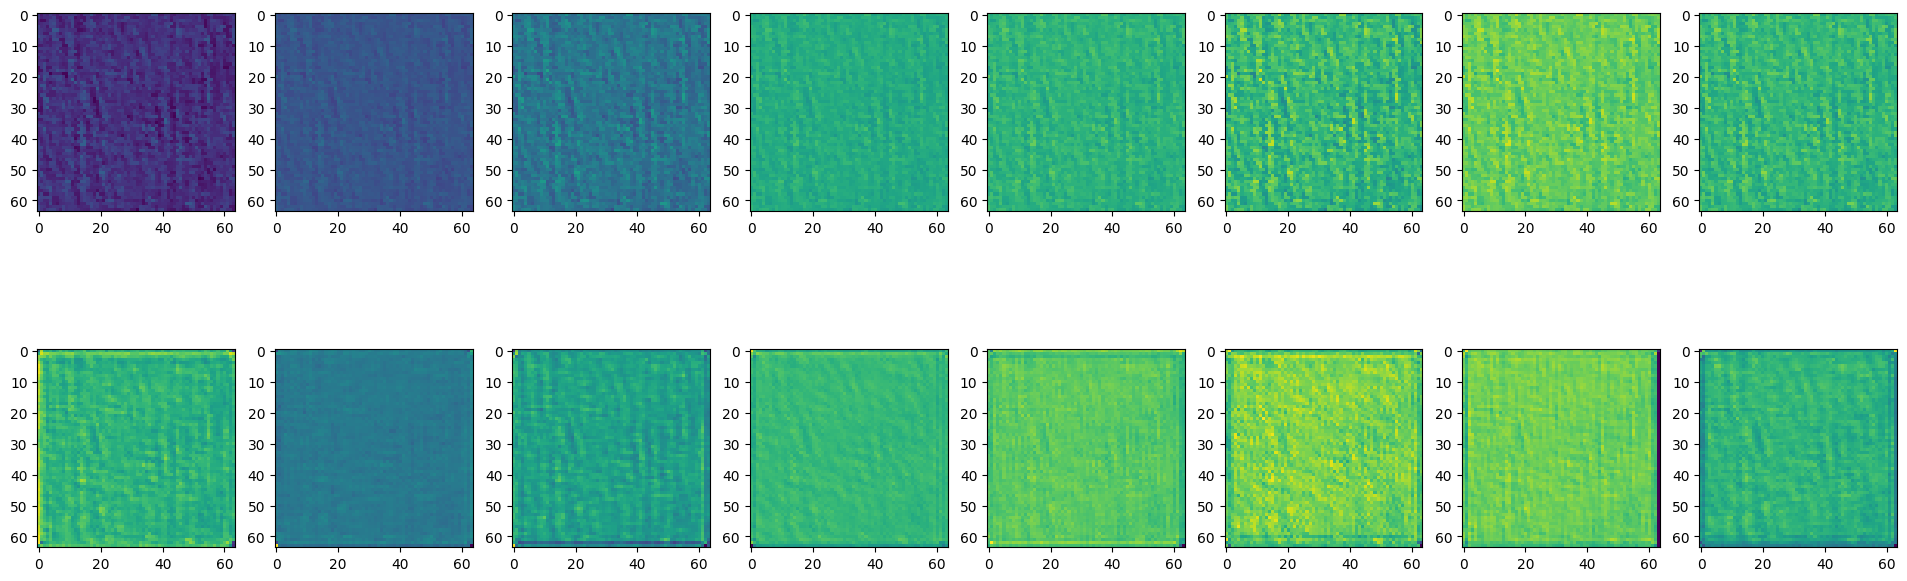

In [26]:
## Test Model
avg_psnr, avg_ssim, avg_mse = test_and_score_model(final_model, verbose=True, num_samples=128, debug=False, visualize_results=True, visualize_index=0, visualize_band=0)

Testing and Scoring Model...
PSB.SD Bands: Coastal Blue, Blue, Green 1, Green 2, Yellow, Red, Red-Edge, NIR
Average PSNR Per Band: 34.404 40.344 43.354 44.732 46.518 45.715 43.285 44.065 All Bands: 42.802
Average SSIM Per Band: 0.974 0.987 0.990 0.989 0.991 0.989 0.988 0.985 All Bands: 0.987
Average MSE Per Band: 0.00036 0.00009 0.00005 0.00004 0.00002 0.00003 0.00005 0.00004 All Bands: 0.00009
y range: 0.014568895 0.056587 0.45088825
ypred  : 0.0 0.061546147 0.7818409


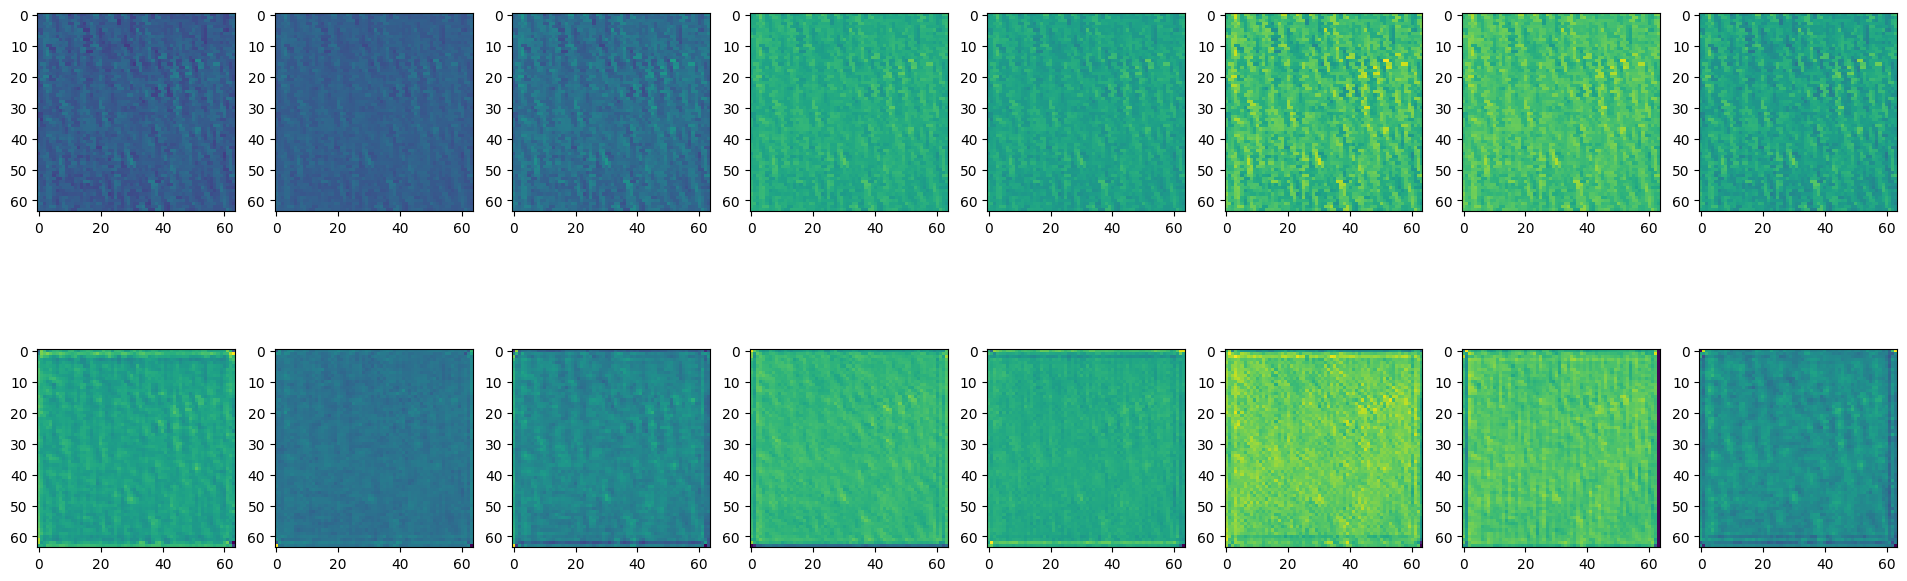

In [27]:
## Test Model
avg_psnr, avg_ssim, avg_mse = test_and_score_model(best_model, verbose=True, num_samples=128, debug=False, visualize_results=True, visualize_index=0, visualize_band=0)

In [123]:
model.save("./saved_models/temp/asdf.keras")

In [77]:
avg_psnr

31.62634021957396

In [78]:
avg_ssim

0.8623859927359433

In [79]:
avg_mse

0.0006904384368934478

In [7]:
## Scratch ##

0

Testing and Scoring Model...
PSB.SD Bands: Coastal Blue, Blue, Green 1, Green 2, Yellow, Red, Red-Edge, NIR
Average PSNR Per Band: 37.122 35.869 38.654 42.498 39.001 26.478 39.013 37.837
Average SSIM Per Band: 0.972 0.959 0.967 0.979 0.962 0.044 0.962 0.948
Average MSE Per Band: 0.000 0.000 0.000 0.000 0.000 0.002 0.000 0.000


In [1]:
def grid_search(param_grid, num_runs=3):
    results = []
    
    for unet_depth in param_grid['unet_depth']:
        for num_filters_base in param_grid['num_filters_base']:
            for conv_block_size in param_grid['conv_block_size']:
                for do_batchnorm in param_grid['do_batchnorm']:
                    for activation in param_grid['activation']:
                        # Initialize lists to store metrics for averaging
                        psnrs, ssims, mses = [], [], []
                        
                        # Run each configuration `num_runs` times
                        for run in range(num_runs):
                            print(f"Running model with unet_depth={unet_depth}, num_filters_base={num_filters_base}, "
                                  f"conv_block_size={conv_block_size}, do_batchnorm={do_batchnorm}, activation={activation} (Run {run+1}/{num_runs})")
                            
                            # Generate and train the U-Net model
                            model = generate_unet_model(unet_depth, num_filters_base, conv_block_size, do_batchnorm, activation)
                            model = train_model(model, batch_size=32, num_epochs=10, learning_rate=0.001)  # Adjust params as needed
                            
                            # Evaluate the model
                            avg_psnr, avg_ssim, avg_mse = test_and_score_model(model, num_samples=10)
                            
                            # Store the results
                            psnrs.append(avg_psnr)
                            ssims.append(avg_ssim)
                            mses.append(avg_mse)

                        # Calculate the average metrics for the hyperparameter combination
                        results.append({
                            'unet_depth': unet_depth,
                            'num_filters_base': num_filters_base,
                            'conv_block_size': conv_block_size,
                            'do_batchnorm': do_batchnorm,
                            'activation': activation,
                            'avg_psnr': np.mean(psnrs),
                            'avg_ssim': np.mean(ssims),
                            'avg_mse': np.mean(mses),
                        })
                        
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Save the results to a CSV file
    results_df.to_csv('grid_search_results.csv', index=False)
    print("Grid search results saved to grid_search_results.csv")
                        

In [ ]:
import xarray as xr
import hvplot.xarray

def get_global_min_max(y, y_pred):
    global_min = min(np.min(y), np.min(y_pred))
    global_max = max(np.max(y), np.max(y_pred))
    return global_min, global_max

def visualize_comparison(y, y_pred, wavelength=385, num_channels=8):
    # Convert numpy arrays to xarray DataArray
    y_xarray = xr.DataArray(y, dims=["batch", "height", "width", "channels"], coords={"wavelengths": np.arange(385, 385+num_channels)})
    y_pred_xarray = xr.DataArray(y_pred, dims=["batch", "height", "width", "channels"], coords={"wavelengths": np.arange(385, 385+num_channels)})

    # Select the closest wavelength to the provided value
    y_wavelength = y_xarray.sel(wavelengths=wavelength, method='nearest')
    y_pred_wavelength = y_pred_xarray.sel(wavelengths=wavelength, method='nearest')

    # Get the global min and max values from both y and y_pred to use the same color scale
    global_min, global_max = get_global_min_max(y_wavelength.values, y_pred_wavelength.values)

    # Normalize both y and y_pred using the global min and max for consistent color scaling
    y_norm = (y_wavelength - global_min) / (global_max - global_min)
    y_pred_norm = (y_pred_wavelength - global_min) / (global_max - global_min)

    # Visualize using hvplot
    plot_y = y_norm.hvplot.image(cmap='viridis', aspect='equal', frame_width=720).opts(
        title=f"Ground Truth Reflectance at {wavelength} nm"
    )

    plot_y_pred = y_pred_norm.hvplot.image(cmap='viridis', aspect='equal', frame_width=720).opts(
        title=f"Predicted Reflectance at {wavelength} nm"
    )

    # Display both plots side by side
    return plot_y + plot_y_pred

In [ ]:
# class CustomDataGenerator2(tf.keras.utils.Sequence):
#     def __init__(self, x_chip_path_dir, y_chip_path_dir, batch_size, shuffle=True):
#         self.x_chip_path_dir = x_chip_path_dir
#         self.y_chip_path_dir = y_chip_path_dir

#         # List all files in the directories
#         self.x_chip_path_list = glob(os.path.join(self.x_chip_path_dir, '*'))
#         self.y_chip_path_list = glob(os.path.join(self.y_chip_path_dir, '*'))

#         self.num_files = len(self.x_chip_path_list)
#         assert len(self.x_chip_path_list) == len(self.y_chip_path_list), \
#             "Mismatch between X and Y files."

#         self.index_path = np.arange(self.num_files)
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def on_epoch_end(self):
#         """Shuffle data at the end of each epoch."""
#         if self.shuffle:
#             np.random.shuffle(self.index_path)

#     def __len__(self):
#         """Number of batches per epoch."""
#         return int(np.floor(self.num_files / self.batch_size))

#     def __getitem__(self, index):
#         """Generate one batch of data."""
#         # Indices for this batch
#         batch_indices = self.index_path[index * self.batch_size:(index + 1) * self.batch_size]

#         # Initialize arrays
#         X, Y = [], []
#         for idx in batch_indices:
#             x = np.load(self.x_chip_path_list[idx])
#             y = np.load(self.y_chip_path_list[idx])

#             # Ensure shapes match model requirements
#             X.append(x)
#             Y.append(y)

#         # Convert lists to NumPy arrays
#         X = np.asarray(X, dtype=np.float32)  # Ensure compatible dtype
#         Y = np.asarray(Y, dtype=np.float32)
        
#         print("X shape:", X.shape)
#         print("Y shape:", Y.shape)
#         print("X dtype:", X.dtype)
#         print("Y dtype:", Y.dtype)

#         # Ensure that X and Y are 4D arrays (for Conv2D, for example)
#         # X shape should be (batch_size, height, width, channels), if not already
#         if X.ndim == 3:  # If it is 3D, add a channels dimension (e.g., grayscale image)
#             X = np.expand_dims(X, axis=-1)  # Convert shape to (batch_size, height, width, 1)
        
#         # Check for nested structures or unexpected object types inside X or Y
#         print(f"X is a numpy array: {isinstance(X, np.ndarray)}")
#         print(f"Y is a numpy array: {isinstance(Y, np.ndarray)}")

#         # Check if the arrays are consistent and fully flattened
#         try:
#             X = np.array(X, dtype=np.float32)
#             Y = np.array(Y, dtype=np.float32)

#             # Debug: check the contents of X and Y
#             print(f"X[0]: {X[0]}")
#             print(f"Y[0]: {Y[0]}")
#         except Exception as e:
#             print(f"Error while checking array structure: {e}")

#         # Try converting to TensorFlow tensors
#         try:
#             X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
#             Y_tensor = tf.convert_to_tensor(Y, dtype=tf.float32)

#             print(f"X tensor shape: {X_tensor.shape}")
#             print(f"Y tensor shape: {Y_tensor.shape}")
#         except ValueError as e:
#             print(f"Error converting to tensor: {e}")
#             print(f"X: {X}")
#             print(f"Y: {Y}")
#             raise e

#         return X_tensor, Y_tensor